In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, false_discovery_control
from collections import Counter

In [2]:
nas_dir = "/home/jaejoong/cocoanlab02"
dat_dir = os.path.join(nas_dir, "projects/AIDA/dataset")
result_dir = os.path.join(nas_dir, "projects/AIDA/results")

In [3]:
all_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_df.csv"))
all_resp_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_resp_df.csv"))
all_liwc_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_liwc_df.csv"))

In [4]:
Q_desc = ["Q1: Anhedonia", # Diminished interest or pleasure
          "Q2: Depressed mood",
          "Q3: Sleep disturbance", # Insomnia or hypersomnia
          "Q4: Fatigue", # Fatigue or loss of energy
          "Q5: Appetite disturbance", # Poor appetite or overeating
          "Q6: Worthlessness", # Feelings of worthlessness or guilt
          "Q7: Poor concentration", # Diminished ability to think or concentrate
          "Q8: Psychomotor disturbance", # Psychomotor agitation or retardation
          "Q9: Positive sentiment",
          "Q10: Negative sentiment",
          "Q11: Self-focused language",
          "Q12: Present-focused language",
          "Q13: Emotion differentiation",
          "Q14: Mindreading",
          "Q15: Catastrophizing",
          "Q16: All-or-nothing thinking",
          "Q17: Emotional reasoning",
          "Q18: Labeling",
          "Q19: Mental filter",
          "Q20: Overgeneralization",
          "Q21: Personalization",
          "Q22: Should statements",
          "Q23: Disqualifying the positive"] # Minimizing or disqualifying the positive

In [5]:
def save_colorbar(cmap, filename):
    fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap=cmap), cax=ax, orientation='horizontal')
    cb.outline.set_visible(False)
    ax.set_xticks([])
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

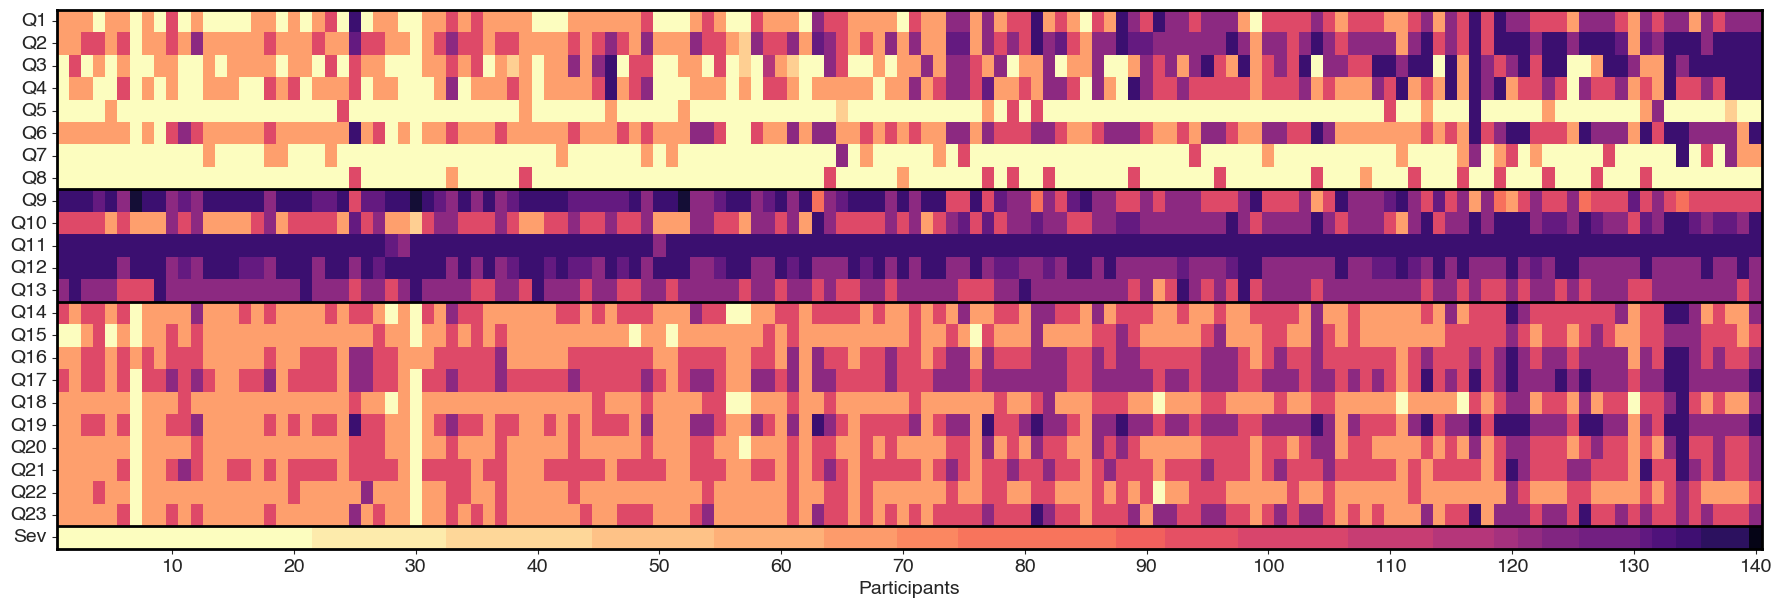

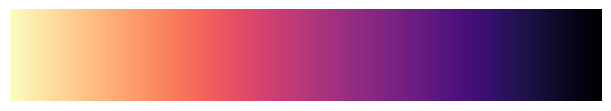

In [6]:
M = all_resp_df.filter(regex="^Q", axis=1)
M = pd.concat([M, all_df["Depression_severity"].rename("Sev") / 24 * 10], axis=1)
M = M[all_df["split"] == "Training"].sort_values(by=["Sev"]).reset_index(drop=True)

plt.figure(figsize=(22, 7))
sns.set_style("ticks", {"font.sans-serif": "Helvetica"})
ax = sns.heatmap(M.T, vmin=0, vmax=10, cmap="magma_r", cbar=None)
for y in [8, 13, 23]:
    ax.hlines(y=y, xmin=0, xmax=len(M), colors='black', linewidth=2)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.xlabel("Participants", fontsize=14)
plt.xticks([x-0.5 for x in range(0,len(M)+1,10)[1:]], labels=range(0,len(M)+1,10)[1:], rotation=0, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.savefig(os.path.join(result_dir, "AIDA_LLM_responses_Training.pdf"), bbox_inches='tight')
plt.show()
save_colorbar("magma_r", os.path.join(result_dir, "AIDA_colorbar_magma_r.pdf"))

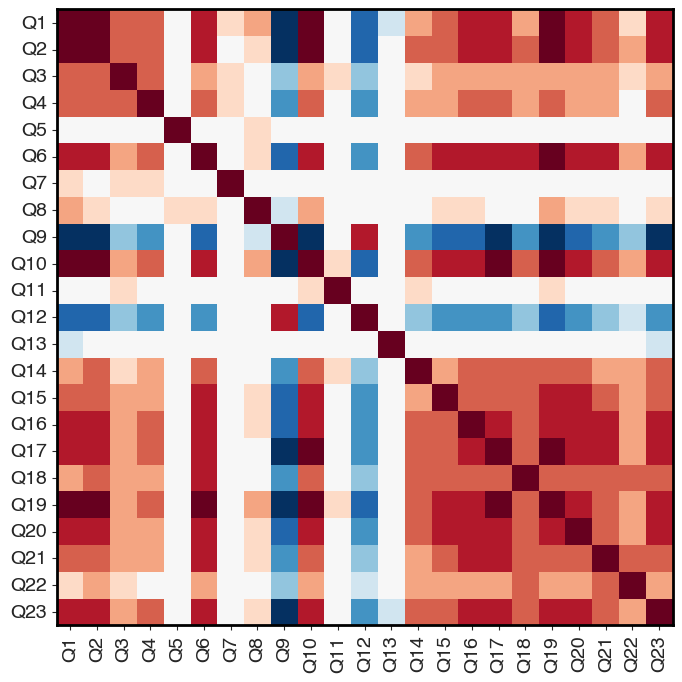

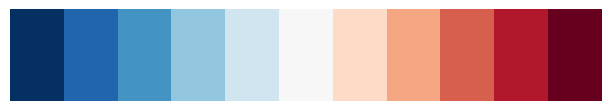

In [7]:
res = spearmanr(all_resp_df[all_df["split"] == "Training"].filter(regex="^Q", axis=1))
M, p = res.correlation, res.pvalue
wh = np.triu_indices_from(p, k=1)
p_fdr = np.full_like(p, np.nan)
p_fdr[wh] = false_discovery_control(p[wh])
p_fdr[(wh[1], wh[0])] = p_fdr[wh]  # Mirror upper to lower
np.fill_diagonal(p_fdr, 0)
M[p_fdr > 0.05] = 0
cmap = mpl.colors.ListedColormap(["#67001F", "#B2182B", "#D6604D", "#F4A582", "#FDDBC7", "#F7F7F7", "#D1E5F0", "#92C5DE", "#4393C3", "#2166AC", "#053061"]).reversed()
xycol_all = [f"Q{i+1}" for i in range(23)]

plt.figure(figsize=(8, 8))
sns.set_style("ticks", {"font.sans-serif": "Helvetica"})
ax = sns.heatmap(M, vmin=-1, vmax=1, cmap=cmap, cbar=None, square=True, xticklabels=xycol_all, yticklabels=xycol_all)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.savefig(os.path.join(result_dir, "AIDA_LLM_responses_corr_Training.pdf"), bbox_inches='tight')
plt.show()
save_colorbar(cmap, os.path.join(result_dir, "AIDA_colorbar_RdBu11.pdf"))

In [8]:
xcol_all = ["PHQ8_1_NoInterest", "PHQ8_2_Depressed", "PHQ8_3_Sleep", "PHQ8_4_Tired",
        "PHQ8_5_Appetite", "PHQ8_6_Failure", "PHQ8_7_Concentration", "PHQ8_8_Psychomotor",
        "tone_pos", "tone_neg", "selffocused", "presentfocused"]
xlabel_all = [f"PHQ-8 item {i+1}" for i in range(8)] + ["LIWC positive sentiment", "LIWC negative sentiment", "LIWC self-focused language", "LIWC present-focused language"]
x_all = pd.concat([all_df, all_liwc_df], axis=1)[xcol_all][all_df["split"] == "Training"].reset_index(drop=True)
ycol_all = [f"Q{i+1}" for i in range(12)]
ylabel_all = Q_desc[:12]
y_all = all_resp_df[ycol_all][all_df["split"] == "Training"].reset_index(drop=True)

res = [spearmanr(x_all.iloc[:,item], y_all.iloc[:,item]) for item in range(x_all.shape[1])]
res = {"r": [r.statistic for r in res], "p": [r.pvalue for r in res], "p_fdr": false_discovery_control([r.pvalue for r in res]).tolist()}

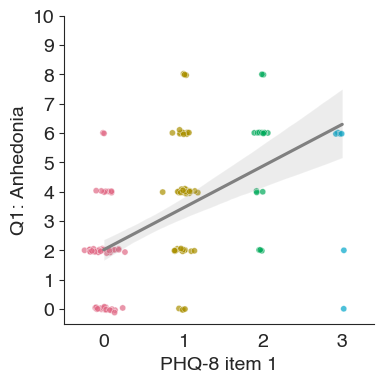

r = 0.58, p-val = 7.1E-14 (0.0000), FDR p-val = 2.8E-13 (0.0000)


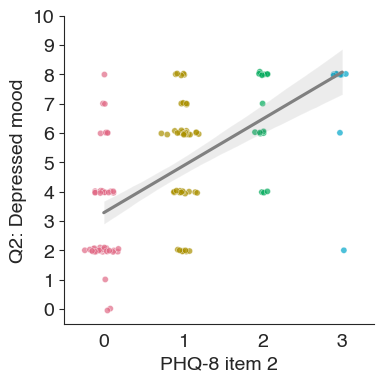

r = 0.65, p-val = 2.7E-18 (0.0000), FDR p-val = 3.3E-17 (0.0000)


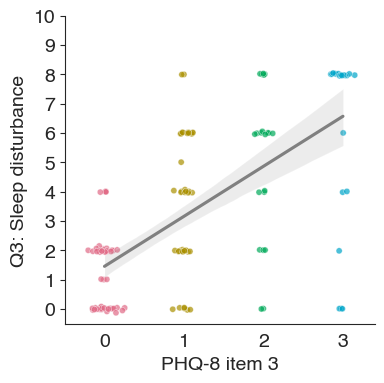

r = 0.63, p-val = 9.2E-17 (0.0000), FDR p-val = 5.5E-16 (0.0000)


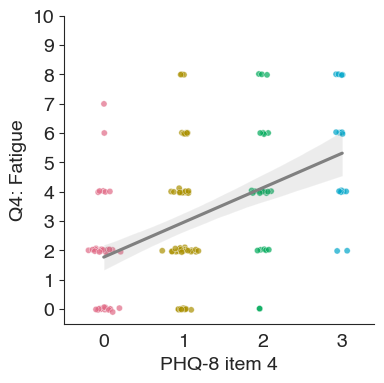

r = 0.49, p-val = 6.2E-10 (0.0000), FDR p-val = 1.5E-09 (0.0000)


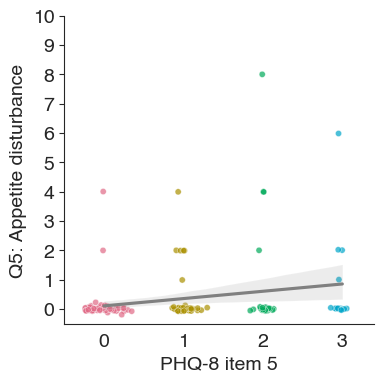

r = 0.24, p-val = 3.6E-03 (0.0036), FDR p-val = 6.1E-03 (0.0061)


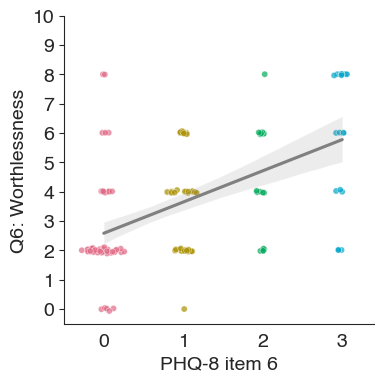

r = 0.53, p-val = 1.9E-11 (0.0000), FDR p-val = 5.8E-11 (0.0000)


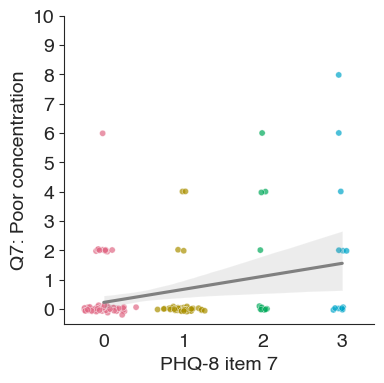

r = 0.19, p-val = 2.8E-02 (0.0281), FDR p-val = 3.8E-02 (0.0375)


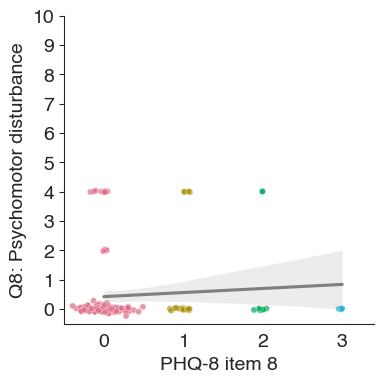

r = 0.09, p-val = 2.9E-01 (0.2929), FDR p-val = 2.9E-01 (0.2929)


In [9]:
for item in range(8):
    x = x_all.iloc[:, item]
    y = y_all.iloc[:, item]
    
    xy_counts = Counter(zip(x, y))
    np.random.seed(42)
    x_jitt = [xi + np.random.normal(0, 0.005 + 0.02 * xy_counts[(xi, yi)]**0.5) for xi, yi in zip(x, y)]
    y_jitt = [yi + np.random.normal(0, 0.005 + 0.007 * xy_counts[(xi, yi)]**0.5) for xi, yi in zip(x, y)]
    
    plt.figure(figsize=(4, 4))
    sns.set_style("ticks", {"font.sans-serif": "Helvetica", "xtick.bottom": False})
    sns.scatterplot(x=x_jitt, y=y_jitt, hue=x, palette=["#E16A86", "#AA9000", "#00AA5A", "#00A6CA"], s=20, alpha=0.7, legend=False)
    sns.regplot(x=x, y=y, scatter=False, seed=42, color="gray")
    sns.despine()
    plt.xlim([-0.5, 3.4])
    plt.ylim([-0.5, 10])
    plt.xlabel(f"{xlabel_all[item]}", fontsize=14)
    plt.ylabel(f"{ylabel_all[item]}", fontsize=14)
    plt.xticks(range(4), fontsize=14)
    plt.yticks(range(11), fontsize=14)
    plt.savefig(os.path.join(result_dir, f"AIDA_PHQ-8_item{item+1}_vs_LLM_{ycol_all[item]}_Training.pdf"), bbox_inches='tight')
    plt.show()
    print(f"r = {res["r"][item]:.2f}, p-val = {res["p"][item]:.1E} ({res["p"][item]:.4f}), FDR p-val = {res["p_fdr"][item]:.1E} ({res["p_fdr"][item]:.4f})")

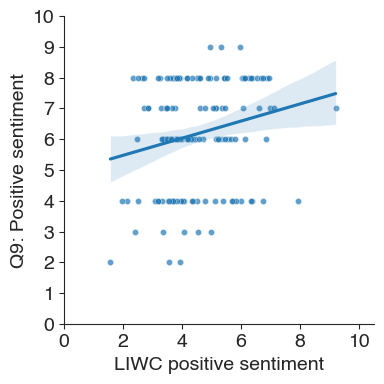

r = 0.20, p-val = 1.6E-02 (0.0165), FDR p-val = 2.5E-02 (0.0247)


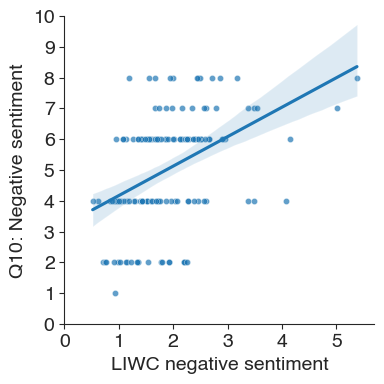

r = 0.47, p-val = 5.7E-09 (0.0000), FDR p-val = 1.1E-08 (0.0000)


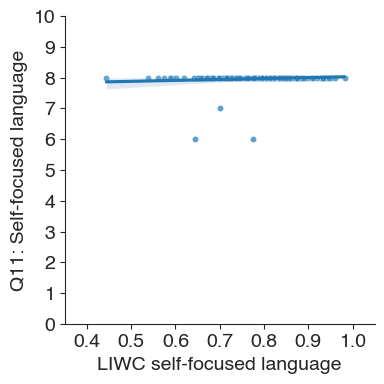

r = 0.14, p-val = 9.4E-02 (0.0942), FDR p-val = 1.0E-01 (0.1027)


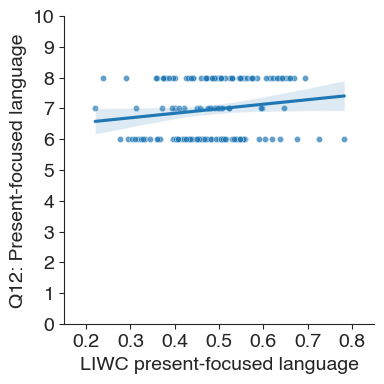

r = 0.17, p-val = 3.9E-02 (0.0393), FDR p-val = 4.7E-02 (0.0472)


In [10]:
xlim_list = {8: [0, 10.5], 9: [0, 5.7], 10: [0.35, 1.05], 11: [0.15, 0.85]}
for item in range(8,12):
    x = x_all.iloc[:, item]
    y = y_all.iloc[:, item]

    plt.figure(figsize=(4, 4))
    sns.set_style("ticks", {"font.sans-serif": "Helvetica"})
    sns.scatterplot(x=x, y=y, s=20, alpha=0.7, legend=False, color="#1F77B4")
    sns.regplot(x=x, y=y, scatter=False, seed=42, color="#1F77B4")
    sns.despine()
    plt.xlim(xlim_list[item])
    plt.ylim([0, 10])
    plt.xlabel(f"{xlabel_all[item]}", fontsize=14)
    plt.ylabel(f"{ylabel_all[item]}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(range(11), fontsize=14)
    plt.savefig(os.path.join(result_dir, f"AIDA_LIWC_{xcol_all[item]}_vs_LLM_{ycol_all[item]}_Training.pdf"), bbox_inches='tight')
    plt.show()
    print(f"r = {res["r"][item]:.2f}, p-val = {res["p"][item]:.1E} ({res["p"][item]:.4f}), FDR p-val = {res["p_fdr"][item]:.1E} ({res["p_fdr"][item]:.4f})")